

```
# This is formatted as code
```

# Face or not detector
Train PCA on lfw_crop people dataset
Then use PCA projections on a different people dataset and cartoon dataset to see if it can distinguish between people and not people

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
from scipy import linalg
from random import uniform
from sklearn.decomposition import PCA
import cv2
import bz2
import pickle
import _pickle as cPickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier



In [96]:
# Mount directories
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# import my utility functions
import sys
sys.path.append('/content/gdrive/My Drive/CSCI1430_Final_Project/')
from utils import *

In [0]:
# This function wasn't working in the utils file
import bz2
import pickle
import _pickle as cPickle
"""
Load any compressed pickle file
"""
def decompress_pickle(file):
  data = bz2.BZ2File(file, 'rb')
  data = cPickle.load(data)
  return data


Get Images

13233


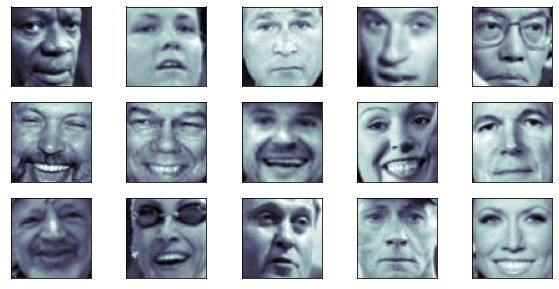

In [100]:
# get lfw crop images for training PCA
path = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/lfw_crop.pbz2"
lfw_crop = decompress_pickle(path)

lfw_crop = np.asarray(lfw_crop)

num_images, height, width = lfw_crop.shape
# Number of people in dataset
print(len(lfw_crop))
show_images_in_dataset(lfw_crop)

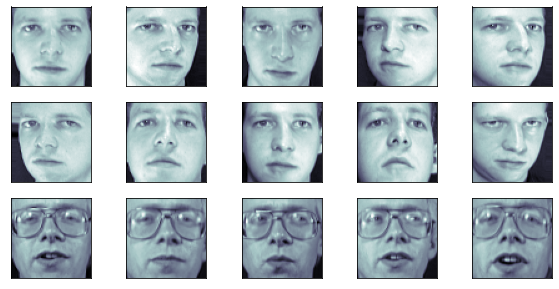

In [101]:
# get olivetti images
olivetti = fetch_olivetti_faces()
olivetti_set = olivetti.images
show_images_in_dataset(olivetti_set)

In [102]:
# get cartoons
path = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/cartoon_set_2k_greyscale.pbz2"
cartoon_set = decompress_pickle(path)

cartoon_set = np.asarray(cartoon_set)

# Number of people in dataset, should be 10k. There's also a larger dataset but we don't need it
print(len(cartoon_set))

num_cartoons, _, _ = cartoon_set.shape


3000


original images


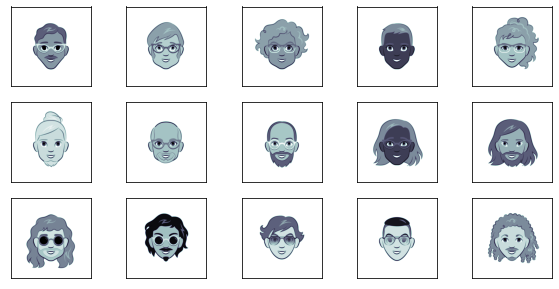

In [103]:
show_images_in_dataset(cartoon_set)
print("original images")

In [0]:
# zoom into images
zoom_cartoon_set = cartoon_set[:, 125:375, 125:375]

zoomed images


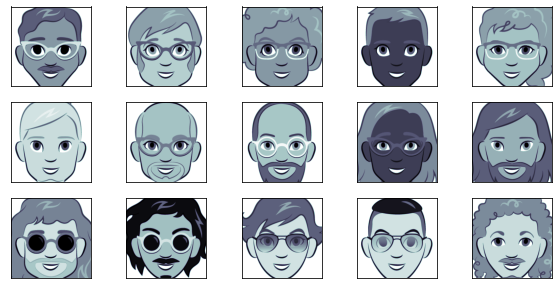

In [140]:
# img_ = cartoon_set[0]
# imgplot = plt.imshow(img_[100:400, 100:400], cmap=plt.cm.bone)
show_images_in_dataset(zoom_cartoon_set)

print("zoomed images")

resized images


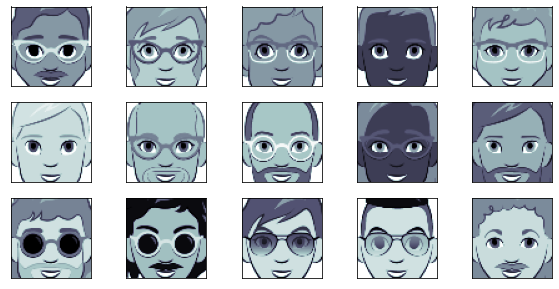

In [134]:
# Reshape cartoons to be 64,64 to match dimensions of lfw_crop
resized_cartoons = np.zeros((num_cartoons, height, width))

for i in range(num_cartoons):
  resized_cartoons[i] = cv2.resize(zoom_cartoon_set[i], (height, width))


show_images_in_dataset(resized_cartoons)
print("resized images")

In [135]:
# combine datasets and labels
# 1 = face
# 0 = not face
olive_labels = np.ones(len(olivetti_set))
cartoon_labels = np.zeros(len(resized_cartoons[:400]))
print(olive_labels.shape)
print(cartoon_labels.shape)
labels = np.concatenate((olive_labels, cartoon_labels[:400]))
print(labels.shape)

print(resized_cartoons[:400].shape)
print(olivetti_set.shape)
images = np.concatenate((olivetti_set, resized_cartoons[:400]))
print(images.shape)

(400,)
(400,)
(800,)
(400, 64, 64)
(400, 64, 64)
(800, 64, 64)


In [0]:
# Train pca only on lfw_crop

# choosing 250 based off previous experiments
num_components=250
# using my own pca method
data_pca, eigenvecs, singular_vals, mean_face = pca_using_svd(lfw_crop.reshape(-1, height*width), num_components)

In [136]:
# Project training data down to PCA components
image_projections = np.dot((images.reshape(-1, height*width) - mean_face.reshape(-1)), eigenvecs.T)
print(image_projections.shape)
# Shuffle data and split into train and test
# X_train, X_test, y_train, y_test = train_test_split(image_projections, labels, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(images.reshape(-1, height*width), labels, test_size=0.33, random_state=42)



(800, 250)


In [137]:
# Now train classifer
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [138]:
acc = knn.score(X_test, y_test)
print("Accuracy at predicting face vs cartoon: {}".format(acc))


Accuracy at predicting face vs cartoon: 1.0
